In [2]:
import sys
sys.path.append("..")

import sympy
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import tensorflow as tf
import tensorflow_quantum as tfq
import cirq

from cv_ops import PositionOp, MomentumOp
from cv_subroutines import centeredQFT
from tests.util.cvutil import domain_bin

In [3]:
def U_mix(qubits, gamma):
    """
    prepare a unitary mixing operator for CV-QAOA, U=e^(-i*gamma*1/2*p^2)
    Args:
        qubits (list [qubits]): list of qubits that contain the bits
        gamma: QAOA trainable parameter
    Returns:
        (circuit): the mixing circuit for CV-QAOA
    """
    d = 2 ** len(qubits)
    return centeredQFT(qubits, inverse=True) + tfq.util.exponential(operators = [(1/2) * MomentumOp(qubits).op ** 2], coefficients = gamma) + centeredQFT(qubits)

def H_cost_poly(qubits, poly):
    """
    prepare a cost hamiltonian from a specific polynomial cost function
    Args:
        qubits (list [qubits]): list of qubits that contain the bits
        poly: (list [float]): list of polynomial coefficients that define cost function
    Returns:
        (circuit): the cost Hamiltonian operator for CV-QAOA
    """
    H_c = cirq.PauliSum()
    for q in qubits:
        # Add Identity Operator for constant coefficient
        H_c += cirq.PauliString((poly[0]/len(qubits))*cirq.I(q))
    for idx, p in enumerate(poly[1:]):
        # Add powers of Position Operator for non-constant coefficients
        temp_op = p * PositionOp(qubits).op
        for _ in range(idx):
            temp_op *= PositionOp(qubits).op
        H_c += temp_op

    return H_c

In [4]:
def generate_parameters(p):
    """
    generate the sympy symbol for the QAOA parameters, eta and gamma
    Args:
        p (int): the number of QAOA layers
    Returns:
        (sympy symbols): the symbols used for QAOA training
    """
    param_list = ['a','b']
    for _ in range(p - 1):
        param_list += [chr(ord(param_list[-1]) + 1), chr(ord(param_list[-1]) + 2)]
    param_string = param_list[0]
    for param in param_list[1:]:
        param_string += ' ' + param
    return sympy.symbols(param_string)

def qaoa_circuit(qubits, poly, p, qaoa_parameters):
    """
    generate the ansatz circuit for CV-QAOA
    Args:
        qubits (list [qubits]): list of qubits that contain the bits
        poly (list [float]): list of polynomial coefficients that define cost function
        p (int): the number of QAOA layers
        qaoa_parameters (sympy symbols): the symbols used for QAOA training
    """
    circuit = cirq.Circuit()
    for idx in range(p):
        # Interleave cost and mixing layers
        circuit += tfq.util.exponential(operators = [H_cost_poly(qubits, poly)], coefficients = qaoa_parameters[2*idx:2*idx+1])
        circuit += U_mix(qubits, qaoa_parameters[2*idx+1:2*idx+2])
    return circuit

# Creates a circuit of all Hadamard gates
def hadamard_circuit(qubits):
    return cirq.Circuit([cirq.H(q) for q in qubits])

In [5]:
def find_optimal_qaoa_params(qaoa_model, input_circs, optimizer, tol):
    """
    trains and optimizes QAOA parameters
    Args:
        qaoa_model (keras model): the qaoa circuit model to train on
        input_circs (cirq circuit): a circuit to run as input to the qaoa model
        optimizer (keras optimizer): a classical optimizer for the QAOA loop
        tol (float): a tolerance below which the optimization stops
    Return:
        (list [float]): a list of the loss function (corresponding to the 
                        function value to minimize) over the course of training
    """
    old_func_val = np.inf
    vals = []
    diff = np.inf
    iter_num = 0
    # While consecutive values are further apart than the tolerance
    while (diff > tol):
        if (iter_num + 1) % 100 == 0:
            print("Iteration " + str(iter_num + 1) + "\nFunction Value: " + str(vals[-1]))
        with tf.GradientTape() as tape:
            func_val = qaoa_model(tfq.convert_to_tensor(input_circs))
        gradients = tape.gradient(func_val, qaoa_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, qaoa_model.trainable_variables))
        func_val = func_val.numpy()[0][0]
        vals.append(func_val)
        diff = abs(func_val - old_func_val)
        old_func_val = func_val
        iter_num += 1
    return vals

In [6]:
def run_qaoa(poly_to_optimize, precision):
    
    # This defines the dynamic range of the discretization
    n_qubits = precision
    qubits = [cirq.GridQubit(0,i) for i in range(n_qubits)]
    
    # Number of QAOA layers
    p = 10
    qaoa_parameters = generate_parameters(p)

    learning_rate = 0.01
    optimizer  = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tol = 1e-6
    
    input_circs = [hadamard_circuit(qubits)]
    qaoa_circ = qaoa_circuit(qubits, poly_to_optimize, p, qaoa_parameters)
    model_readout = H_cost_poly(qubits, poly_to_optimize)
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
    qaoa_pqc = tfq.layers.PQC(qaoa_circ, model_readout, differentiator=tfq.differentiators.Adjoint())(inputs)
    qaoa_model = tf.keras.models.Model(inputs=inputs, outputs=qaoa_pqc)

    func_val_history = find_optimal_qaoa_params(qaoa_model, input_circs, optimizer, tol)

    # Read out the optimal paramters and sample from the final state 1000 times
    params = qaoa_model.trainable_variables
    add = tfq.layers.AddCircuit()
    output_circuit = add(tfq.convert_to_tensor(input_circs), append = qaoa_circuit(qubits, poly_to_optimize, p, qaoa_parameters))

    sample_layer = tfq.layers.Sample()
    output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params, repetitions=1000)

    return output

def plot_output(output):
    count = Counter(["".join([str(bit) for bit in bitstring]) for bitstring in output.numpy()[0]])
    cirq.plot_state_histogram(count, plt.subplot())
    plt.show()
    # plt.savefig("output_histogram.png")

In [7]:
def plot_cost_function(poly, precision):
    limits = [-np.sqrt(2 * np.pi * 2 ** precision) / 2,
               np.sqrt(2 * np.pi * 2 ** precision) / 2]
    domain = [limits[0] + i*((limits[1]-limits[0])/(2**precision)) for i in range(2**precision)]
    xs = np.arange(limits[0],limits[1],0.01)
    ys = [0] * len(xs)
    for idx, x in enumerate(xs):
        ys[idx] = poly[0]
        for pow, coeff in enumerate(poly[1:]):
            temp_val = coeff*x
            for _ in range(pow):
                temp_val *= x
            ys[idx] += temp_val
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.plot(xs, ys)
    ax.set_xlabel('discretization')
    ax.set_title('cost function value')
    ax.set_xticks(domain)
    ax.set_xticklabels([domain_bin(domain_val, precision) for domain_val in domain], rotation=90)
    plt.show()

Iteration 100
Function Value: 4.700457
Iteration 200
Function Value: 4.175939
Iteration 300
Function Value: 4.0214853


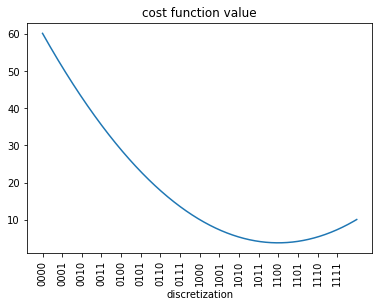

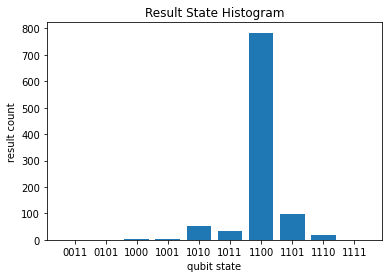

In [9]:
# Polynomial, specified as: poly[0] + poly[1]*x + poly[2]*x^2 + ...
# This polynomial has a minimum at x=2.5, which corresponds almost exactly
# to the bitstring 1100 (for 4-bits)
poly = [10.0, -5.0, 1.0]
precision = 4

output = run_qaoa(poly, precision)
plot_cost_function(poly, precision)
plot_output(output)